# Hello hello,
Welcome to the JQ Model Aquarium, the (future)? home of many models whose intelligence is comparable to the average goldfish

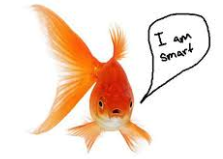

In [12]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import gc
import torchnet as tnt
from tqdm import tqdm_notebook # for-loop progress bar in notebook

# plt setup and the gpu setup
plt.ion()
use_gpu = torch.cuda.is_available()

In [2]:
print(use_gpu) #hallelujah

True


In [3]:
# ========================================
# Step 1. define data transform
#
# Including different forms of data augmentation
# One will include nearly all types (excluding random crops, etc. that may remove handwriting.)
# The other will include a selected set of augmentations
# Keeping 'train', 'val', and 'test' transforms just in case we want to include different functionalities
# ========================================

print("Set up data transforms.")
#NOTE that images are typically 1000 by ~1500+
#we run out of memory

img_input_size = 64 

selected_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Grayscale(), # not sure why the current input is not grayscale, do grayscale conversion
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    # should not do random transformation in val or test set
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
}
data_transforms = selected_transforms

Set up data transforms.


In [4]:
# ========================================
# Step 2. define and load data
#
# TODO: Suggest not using data loader to load the images. Because it is slow. Every epochs, you load the 
# image data again to the RAM and then from RAM to GPU RAM. That takes a lot of time. Since the images are 
# <1GB, you can preload the images into RAM first, that will make you training way faster. 

# Note: you only has about 200MB of images, it's small. It should not take much time to load!
# ========================================
print("Create dataset and dataloader")

# hyperparameter
batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster

# data location
book_data_dir = "/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images"
set_types = ['train', 'val', 'test']

# test books are currently arbitrarily set
test_books = set(["Albin", "Dryden"])

# Get the list of all books in the data set
books_in_data = set([b for b in os.listdir(book_data_dir)
                 if os.path.isdir(os.path.join(book_data_dir, b))])

# Create a dict of datasets for each book
book_data_sets = {b : {t : datasets.ImageFolder(os.path.join(book_data_dir, b), 
                                                transform = data_transforms[t])#, transform=test_transform)
                      for t in set_types}
                 for b in books_in_data}

# create a dict of dataloaders, book_data_loaders['Albin']['train']
book_data_loaders = {b : {t : torch.utils.data.DataLoader(book_data_sets[b][t],
                                                          batch_size=batch_size,
                                                          shuffle=True, # make sure you shuffle the data
                                                          num_workers=4)
                          for t in set_types}
                     for b in books_in_data}

Create dataset and dataloader


(1, 64, 64)
(64, 64)


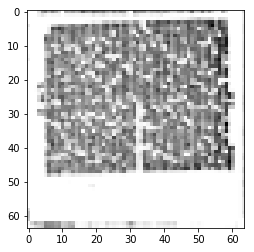

In [5]:
# ========================================
# Check your data to make sure it is correct
# ========================================

for data in book_data_loaders['Defoe']['train']:
    # get the inputs
    inputs, labels = data

    # plot to verify the input is correct
    input1 = inputs[0].numpy()
    print(input1.shape)
    input1 = np.swapaxes(input1,0,2).squeeze()
    print(input1.shape)
    plt.imshow(input1,cmap='gray')
    
    break

In [6]:
# ========================================
# Step 4. define the training process.
#
# TODO: The basic process of train and validation is defined. Please implement the overall average validation 
# confusion matrix, meaning for each validation (after running all epochs), get the confusion matrix for that book,
# repeat this for the rest of 10 books. THen get the overall performance. Also, implement the early-stop as you
# originally has in your code. :) I removed them here for clarity. You can add them back. 
# ========================================



trainLosses = []
valLosses = []
def train(model, criterion, optimizer, data_loaders, num_epochs=25, early_stopping = None):

    # stop the training, validation, and test loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        # looping parameters
        running_loss = 0.0
        
        
        confusion_matrix = tnt.meter.ConfusionMeter(2)
        
        # loop through train and val phase in each epoch
        for phase in ['train', 'val']:
            # check train or val
            if phase == 'train':                
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            # Iterate over each book
            running_loss = 0.0
            
         
            confusion_matrix = tnt.meter.ConfusionMeter(2)
            for book in tqdm_notebook(data_loaders[phase]):
                for data in data_loaders[phase][book]:
                    # get the inputs;  wrap them in Variable and make them into gpu or not
                    inputs, labels = data # input size: [5, 1, 28, 28] ; keep the dummy color channel:1
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    # back
                    if phase == 'train': 
                        loss.backward()
                        optimizer.step()

                    # Add to confusion matrix
                    confusion_matrix.add(outputs.data, labels.data)

                    # statistics
                   
                    running_loss += loss.item()
                    
            
            # report evaluation
            print('Phase:%s' %phase)
            print('Confusion matrix:\n', confusion_matrix.conf)
            if phase == 'train':
                print('train loss', running_loss)
                trainLosses.append(running_loss)
               
            else:
                print('validation loss', running_loss)
                valLosses.append(running_loss)
               
            
        
    return model

In [7]:
def plotLosses(trainLosses,valLosses,title = ""):
    plt.title(title)
    plt.plot(trainLosses,label = "training")
    plt.plot(valLosses,label = "validation")
    #plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

#plotLosses(trainLosses,valLosses,"JQ_MODEL")

In [10]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding = 1).cuda()
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding = 1).cuda()
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5, padding = 1).cuda()
        self.conv2_drop = nn.Dropout2d(p = 0.2)
        self.conv3_drop = nn.Dropout2d(p = 0.1)
      
        #assumes a batch size of 50
        self.fc1 = nn.Linear(1440,64).cuda()
        self.fc2 = nn.Linear(64, 2).cuda()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x

This is model: 1
Net1(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.2)
  (conv3_drop): Dropout2d(p=0.1)
  (fc1): Linear(in_features=1440, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)
Epoch 1/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[  14  618]
 [  62 1457]]
train loss 30.907700896263123


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.991524755954742
Epoch 2/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   5  627]
 [ 102 1417]]
train loss 30.363868802785873


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.9300267696380615
Epoch 3/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 30.71966651082039


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.93240350484848
Epoch 4/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 30.64563673734665


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 8.04121047258377
Epoch 5/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 30.821216702461243


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 8.763346076011658
Epoch 6/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 30.91140314936638


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 8.77668160200119
Epoch 7/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 29.925323992967606


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 8.104786038398743
Epoch 8/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 29.688802242279053


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 8.087064027786255
Epoch 9/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 29.527569204568863


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 8.046027481555939
Epoch 10/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 29.30900725722313


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.815637826919556
Epoch 11/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 29.076041758060455


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.823838233947754
Epoch 12/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 29.33648180961609


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.852521657943726
Epoch 13/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 29.184023171663284


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.835624635219574
Epoch 14/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 29.08975401520729


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.685066640377045
Epoch 15/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 29.109798938035965


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.587684452533722
Epoch 16/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 29.163019716739655


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.570825815200806
Epoch 17/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 28.87757182121277


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.832473695278168
Epoch 18/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 29.374123752117157


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.621284902095795
Epoch 19/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 29.428680986166


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.634853363037109
Epoch 20/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 29.151121228933334


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.685129135847092
Epoch 21/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 28.723703294992447


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.450848042964935
Epoch 22/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 28.840627193450928


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.428292781114578
Epoch 23/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 28.802041560411453


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.554201662540436
Epoch 24/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 29.088437497615814


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.423992455005646
Epoch 25/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 28.829247176647186


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.524740844964981
Epoch 26/26
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:train
Confusion matrix:
 [[   0  632]
 [   0 1519]]
train loss 28.746445387601852


Widget Javascript not detected.  It may not be installed or enabled properly.



Phase:val
Confusion matrix:
 [[  0 129]
 [  0 538]]
validation loss 7.7641114592552185


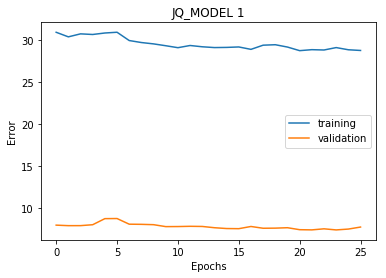

training complete
Total time to train: 0:06:33.491724


In [11]:
import time
import datetime


net1 = Net1()

models = [net1]




model2trainAndVolLosses = dict()
times = []
counter = 1
for m in models:
    print("This is model: " + str(counter))
    print(m)
    start_time = time.time()
    
    trainLosses = []
    valLosses = []

    
    
    
    
    # train parameters
    num_training_epochs = 26
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(m.parameters(), lr=0.001)


    # dataloader parameters
    cross_val_loaders = {}

    # leave-one-book-out cross validation
    for val_book in books_in_data:

        # define the train and validation loaders
        train_books = books_in_data - set([val_book])    
        cross_val_loaders["train"] = {b : book_data_loaders[b]["train"] for b in train_books}
        cross_val_loaders["val"] = {b : book_data_loaders[b]["val"] for b in [val_book]}

    # train
    trained_model = train(m,
                          criterion,
                          optimizer,
                          cross_val_loaders,
                          num_epochs=num_training_epochs)

    # remove the break as needed
    # break
    plotLosses(trainLosses,valLosses,"JQ_MODEL " + str(counter))
    
   
    print("training complete")
    timeTrained = (time.time() - start_time)
    print("Total time to train: " + str(datetime.timedelta(seconds=timeTrained)))
    times.append(timeTrained)
    
    model2trainAndVolLosses[counter] = (trainLosses,valLosses)
    
    #m.save_state_dict('net' + str(counter) + '.pt')
    #torch.save(m, '/Users/silver/Desktop/buildUCLA/annotations-computervision/' + '26epm_' + str(counter) + '.pt')
    counter += 1
    
    
    